# Functional Encryption - Classification and information leakage

Our start point is the work on encrypted classification using Function Encryption of the paper [Reading in the Dark: Classifying Encrypted Digits with Functional Encryption](https://eprint.iacr.org/2018/206), and the associated [GitHub repository](https://github.com/edufoursans/reading-in-the-dark).

More specifically, the paper provides a new Functional Encryption scheme for quadratic multi-variate polynomials, which can under some hypothesis be seen as a single hidden layer neural network with a quadratic activation.
In the paper, the output corresponds to element per class, and it is made in clear. We analyse how this output can disclose information about the initial input or about charasteristics of this input.

To this aim, we have just built a dataset which is very similar to MNIST, used in the original paper but which is composed of 26 letter characters of 5 differents fonts. Our goal is two-fold:
 - Evaluate how the output in clear can be leverage with a public NN to make better prediction than a simple `argmax` function in the character recognition task.
 - Analyse to what extent the output in clear of the model trained for character recognition can reveal information about the font used, using an "adversarial" network.
 
### Purpose

We keep the same structure as before of the network but now try to do a single optimisation step by improving a single loss which contains both objectives and tries to reduce the collateral objective.

More formally, what we want to do is to optimize the following problem:
$ \min_Q [ \min_C l_C(Q, C) - \alpha \min_F l_F(Q, F) ] $


The game is in 3 epoch time:
 - The normal phase where both tasks learn and strenghten before the joint optimisation:
  - `Optimize: Q + C`
  - `Optimize: Freezed(Q) + F`
 - The phase with the joint optimisation, where C and F are updated depending on the Q variations and Q is optimised to reduce the loss `C - alpha * F`:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`
  - `Optimize : Q + [Freezed(C) - alpha * Freezed(F)]`
 - The recovery part, where both tasks recover from the perturbation, `Q` won't change now:
  - `Optimize: Freezed(Q) + C`
  - `Optimize: Freezed(Q) + F`

Contrary to Part 9, we use the same optimiser for all optimisation task. Note that our objective on Q imposes that we take `alpha < loss(F) / loss(C)` so in practice we keep $\alpha \leq 2$.

# 1. Joint optimisation


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as utils

import learn
from learn import load_data, show_results

In [3]:
class Parser:
    """Parameters for the training"""
    def __init__(self):
        self.epochs = 10
        self.sabotage_epochs = 10
        self.recovering_epochs = 10
        self.lr = 0.002
        self.momentum = 0.5
        self.test_batch_size = 1000
        self.batch_size = 64
        self.log_interval = 100

Let's define the model with the describes architecture. Basically you have 3 blocs: 1 quadratic and 2 CNN.

In [4]:
N_CHARS = 26
N_FONTS = 5
class QuadConvNet(nn.Module):
    def __init__(self):
        super(QuadConvNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, 8)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(8, 16)
        self.lin2 = nn.Linear(16, N_CHARS)
        
        # --- FFN for font families
        self.lin3 = nn.Linear(8, 16)
        self.lin4 = nn.Linear(16, N_FONTS)
        
    def quad(self, x):
        """Same as forward up to the junction part
        Used for the collateral training"""
        # --- Quadratic 
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x
    
    def conv_char(self, x):
        # --- FFN
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x
        
    def conv_font(self, x):
        # --- FFN
        x = F.relu(self.lin3(x))
        x = self.lin4(x)
        return x

    def forward_char(self, x):
        x = self.quad(x)
        x = self.conv_char(x)
        return F.log_softmax(x, dim=1)
    
    def forward_font(self, x):
        x = self.quad(x)
        x = self.conv_font(x)
        return F.log_softmax(x, dim=1)
    
    def get_params(self, net):
        """Select the params for a given part of the net"""
        if net == 'quad':
            layers = [self.proj1, self.diag1]
        elif net == 'char':
            layers = [self.lin1, self.lin2]
        elif net == 'font':
            layers = [self.lin3, self.lin4]
        else:
            raise AttributeError(f'{net} type not recognized')
        params = [p for layer in layers for p in layer.parameters()]
        return params
    
    def freeze(self, net):
        """Freeze a part of the net"""
        net_params = self.get_params(net)
        for param in net_params:
            param.requires_grad = False
            
    def unfreeze(self):
        """Unfreeze the net"""
        for param in self.parameters():
            param.requires_grad = True
        
        

Next, we define the train and test functions. They assume the train_load return two labels: the char and the font of some input.

In the training phase we execute the 3 steps as described aboved.

In the test function, we just test the performance for the main and collateral tasks.

In [5]:
def train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Split the two targets
        target_char = target[:, 0]
        target_font = target[:, 1]
        
        
        # Optimize C and F parts of the model with 2 strategies
        if initial_phase:  # Normal optimisation of F
            # Phase 1: Optimise Q + C
            optimizer.zero_grad()
            output = model.forward_char(data)
            loss_char = F.nll_loss(output, target_char)
            loss_char.backward()
            optimizer.step()
        else: # Freezed(Q) optimisation
            # Phase 1: Optimise Freezed(Q) + F
            model.freeze('quad')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)
            loss_char.backward()
            optimizer.step()
            model.unfreeze()
        # Phase 2: Optimise Freezed(Q) + F
        model.freeze('quad')
        output_font = model.forward_font(data)
        loss_font = F.nll_loss(output_font, target_font)
        loss_font.backward()
        optimizer.step()
        model.unfreeze()
        
        if perturbate:
            # Optimize Q
            model.freeze('font')
            model.freeze('char')
            optimizer.zero_grad()
            output_char = model.forward_char(data)
            loss_char = F.nll_loss(output_char, target_char)

            output_font = model.forward_font(data)
            loss_font = F.nll_loss(output_font, target_font)

            loss = loss_char - alpha * loss_font
            loss.backward()
            optimizer.step()
            model.unfreeze()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss Char: {:.6f} Loss Font: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss_char.item(), loss_font.item()))

In [6]:
def test(args, model, test_loader):
    model.eval()
    correct_char = 0
    correct_font = 0
    with torch.no_grad():
        for data, target in test_loader:
            # Split the two targets
            target_char = target[:, 0]
            target_font = target[:, 1]

            # Char evaluation
            output = model.forward_char(data)
            pred = output.argmax(1, keepdim=True)
            correct_char += pred.eq(target_char.view_as(pred)).sum().item()
            
            # Font evaluation
            output = model.forward_font(data)
            pred = output.argmax(1, keepdim=True)
            correct_font += pred.eq(target_font.view_as(pred)).sum().item()

    acc_char = 100. * correct_char / len(test_loader.dataset)
    acc_font = 100. * correct_font / len(test_loader.dataset)
    print('\nTest set: Accuracy Char : {}/{} ({:.2f}%)\n          Accuracy Font : {}/{} ({:.2f}%)'.format(
        correct_char, len(test_loader.dataset), acc_char, correct_font, len(test_loader.dataset), acc_font))

    return acc_char, acc_font

Now we can handle the main function. The only thing that really changes is that we now want to have both labels associated to a input item.

In [7]:
def build_tensor_dataset(data, target):
    """Utility function to cast our data into a normalized torch TensorDataset"""
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([[i[0][0], i[1][0]] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset

Last the main function !

In [8]:
def main(alpha=0):
    """
    Perform a learning phase
    """
    torch.manual_seed(1)
    args = Parser()

    data = load_data()
    train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data
    # Merge the target datasets
    train_target = list(zip(train_target_char, train_target_family))
    test_target = list(zip(test_target_char, test_target_family))

    # We use here the slightly modified version of this function
    train_dataset = build_tensor_dataset(train_data, train_target)
    test_dataset = build_tensor_dataset(test_data, test_target)

    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )

    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
   
    model = QuadConvNet()

    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs_char = []
    test_perfs_font = []
    
    for epoch in range(1, args.epochs + args.sabotage_epochs + args.recovering_epochs + 1):
        initial_phase = epoch <= args.epochs
        if initial_phase:
            print("(initial phase)")
        perturbate = epoch > args.epochs and epoch <= args.epochs + args.sabotage_epochs
        if perturbate:
            print("(perturbate)")
        train(args, model, train_loader, optimizer, epoch, alpha, initial_phase, perturbate)
        test_perf_char, test_perf_font = test(args, model, test_loader)
        test_perfs_char.append(test_perf_char)
        test_perfs_font.append(test_perf_font)

    return test_perfs_char, test_perfs_font, model

In [9]:
results = {}
test_perfs_char_clean, test_perfs_font_clean, model_clean = main(alpha=0)
results["Main task in the normal setting"] = test_perfs_char_clean
results["Collateral task in the normal setting"] = test_perfs_font_clean

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.241490 Loss Font: 1.619655
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.243401 Loss Font: 1.634818
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.125095 Loss Font: 1.670732
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.984154 Loss Font: 1.708088
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.888399 Loss Font: 1.640867
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.595878 Loss Font: 1.645604
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.191660 Loss Font: 1.634457
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.920311 Loss Font: 1.644273
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.738962 Loss Font: 1.688137
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.865170 Loss Font: 1.599646

Test set: Accuracy Char : 4957/10000 (49.57%)
          Accuracy Font : 2659/10000 (26.59%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.318387 Loss Font: 1.608933
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.117435 Loss Font: 1.306534
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.142440 Loss Font: 1.466446
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.235981 Loss Font: 1.445580
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.174490 Loss Font: 1.521461

Test set: Accuracy Char : 9294/10000 (92.94%)
          Accuracy Font : 3947/10000 (39.47%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.186847 Loss Font: 1.429575
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.096837 Loss Font: 1.364297
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.088227 Loss Font: 1.481300
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.195887 Loss Font: 1.197696
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.176588 Loss Font: 1.434108
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.204951 Loss Font: 1.335171
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.099443 Loss Font: 1.244669
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.071223 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.059127 Loss Font: 1.344574
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.096955 Loss Font: 1.362745
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.038264 Loss Font: 1.163785
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.074458 Loss Font: 1.254259
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.057496 Loss Font: 1.258646
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.024605 Loss Font: 1.305933
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.045617 Loss Font: 1.332320
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.142277 Loss Font: 1.252406
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.019476 Loss Font: 1.101295

Test set: Accuracy Char : 9473/10000 (94.73%)
          Accuracy Font : 4333/10000 (43.33%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.032359 Loss Font: 1.437826
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.028821 Loss Font: 1.243466
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.172874 Loss Font: 1.336825
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.129067 Loss Font: 1.480115

Test set: Accuracy Char : 9493/10000 (94.93%)
          Accuracy Font : 4472/10000 (44.72%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.117864 Loss Font: 1.300349
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.062966 Loss Font: 1.292098
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.184147 Loss Font: 1.157818
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.085521 Loss Font: 1.283452
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.034567 Loss Font: 1.163255
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.038528 Loss Font: 1.311681
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.055842 Loss Font: 1.383152
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.088089 Loss Font: 1.277948
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.120493 Loss Font: 1.209706
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.302401 Loss Font: 1.498148

Test set: Accuracy Char : 9508/10000 (95.08%)
          Accuracy Font : 4333

In [11]:
alphas = [0.05, 0.1, 0.2, 0.5, 1, 1.5, 2]
for alpha in alphas:
    test_perfs_char_perturbate, test_perfs_font_perturbate, model_perturbate = main(alpha=alpha)
    results[f"Main task with perturbation alpha={alpha}"] = test_perfs_char_perturbate
    results[f"Collateral task with perturbation alpha={alpha}"] = test_perfs_font_perturbate

Training set 60000 items
Testing set  10000 items
(initial phase)
Train Epoch: 1 [0/60000 (0%)]	Loss Char: 3.241490 Loss Font: 1.619655
Train Epoch: 1 [6400/60000 (11%)]	Loss Char: 3.243401 Loss Font: 1.634818
Train Epoch: 1 [12800/60000 (21%)]	Loss Char: 3.125095 Loss Font: 1.670732
Train Epoch: 1 [19200/60000 (32%)]	Loss Char: 2.984154 Loss Font: 1.708088
Train Epoch: 1 [25600/60000 (43%)]	Loss Char: 2.888399 Loss Font: 1.640867
Train Epoch: 1 [32000/60000 (53%)]	Loss Char: 2.595878 Loss Font: 1.645604
Train Epoch: 1 [38400/60000 (64%)]	Loss Char: 2.191660 Loss Font: 1.634457
Train Epoch: 1 [44800/60000 (75%)]	Loss Char: 1.920311 Loss Font: 1.644273
Train Epoch: 1 [51200/60000 (85%)]	Loss Char: 1.738962 Loss Font: 1.688137
Train Epoch: 1 [57600/60000 (96%)]	Loss Char: 1.865170 Loss Font: 1.599646

Test set: Accuracy Char : 4957/10000 (49.57%)
          Accuracy Font : 2659/10000 (26.59%)
(initial phase)
Train Epoch: 2 [0/60000 (0%)]	Loss Char: 1.318387 Loss Font: 1.608933
Train Epoch

Train Epoch: 10 [38400/60000 (64%)]	Loss Char: 0.117435 Loss Font: 1.306534
Train Epoch: 10 [44800/60000 (75%)]	Loss Char: 0.142440 Loss Font: 1.466446
Train Epoch: 10 [51200/60000 (85%)]	Loss Char: 0.235981 Loss Font: 1.445580
Train Epoch: 10 [57600/60000 (96%)]	Loss Char: 0.174490 Loss Font: 1.521461

Test set: Accuracy Char : 9294/10000 (92.94%)
          Accuracy Font : 3947/10000 (39.47%)
(perturbate)
Train Epoch: 11 [0/60000 (0%)]	Loss Char: 0.186847 Loss Font: 1.429575
Train Epoch: 11 [6400/60000 (11%)]	Loss Char: 0.096967 Loss Font: 1.366989
Train Epoch: 11 [12800/60000 (21%)]	Loss Char: 0.088430 Loss Font: 1.485423
Train Epoch: 11 [19200/60000 (32%)]	Loss Char: 0.195931 Loss Font: 1.203422
Train Epoch: 11 [25600/60000 (43%)]	Loss Char: 0.175513 Loss Font: 1.440112
Train Epoch: 11 [32000/60000 (53%)]	Loss Char: 0.204216 Loss Font: 1.339566
Train Epoch: 11 [38400/60000 (64%)]	Loss Char: 0.101733 Loss Font: 1.252529
Train Epoch: 11 [44800/60000 (75%)]	Loss Char: 0.073976 Loss Fon

Train Epoch: 20 [6400/60000 (11%)]	Loss Char: 0.062392 Loss Font: 1.423428
Train Epoch: 20 [12800/60000 (21%)]	Loss Char: 0.114703 Loss Font: 1.392602
Train Epoch: 20 [19200/60000 (32%)]	Loss Char: 0.038629 Loss Font: 1.197431
Train Epoch: 20 [25600/60000 (43%)]	Loss Char: 0.071004 Loss Font: 1.294890
Train Epoch: 20 [32000/60000 (53%)]	Loss Char: 0.065427 Loss Font: 1.297503
Train Epoch: 20 [38400/60000 (64%)]	Loss Char: 0.023674 Loss Font: 1.357684
Train Epoch: 20 [44800/60000 (75%)]	Loss Char: 0.043856 Loss Font: 1.405920
Train Epoch: 20 [51200/60000 (85%)]	Loss Char: 0.141701 Loss Font: 1.301629
Train Epoch: 20 [57600/60000 (96%)]	Loss Char: 0.019507 Loss Font: 1.161795

Test set: Accuracy Char : 9451/10000 (94.51%)
          Accuracy Font : 4173/10000 (41.73%)
Train Epoch: 21 [0/60000 (0%)]	Loss Char: 0.028824 Loss Font: 1.437330
Train Epoch: 21 [6400/60000 (11%)]	Loss Char: 0.025973 Loss Font: 1.306141
Train Epoch: 21 [12800/60000 (21%)]	Loss Char: 0.176931 Loss Font: 1.388538
Tr

Train Epoch: 29 [57600/60000 (96%)]	Loss Char: 0.125760 Loss Font: 1.451554

Test set: Accuracy Char : 9494/10000 (94.94%)
          Accuracy Font : 4344/10000 (43.44%)
Train Epoch: 30 [0/60000 (0%)]	Loss Char: 0.115213 Loss Font: 1.365921
Train Epoch: 30 [6400/60000 (11%)]	Loss Char: 0.062873 Loss Font: 1.298841
Train Epoch: 30 [12800/60000 (21%)]	Loss Char: 0.165351 Loss Font: 1.227225
Train Epoch: 30 [19200/60000 (32%)]	Loss Char: 0.090093 Loss Font: 1.295395
Train Epoch: 30 [25600/60000 (43%)]	Loss Char: 0.032386 Loss Font: 1.192832
Train Epoch: 30 [32000/60000 (53%)]	Loss Char: 0.045646 Loss Font: 1.383828
Train Epoch: 30 [38400/60000 (64%)]	Loss Char: 0.059404 Loss Font: 1.401089
Train Epoch: 30 [44800/60000 (75%)]	Loss Char: 0.087704 Loss Font: 1.278694
Train Epoch: 30 [51200/60000 (85%)]	Loss Char: 0.136807 Loss Font: 1.192238
Train Epoch: 30 [57600/60000 (96%)]	Loss Char: 0.302572 Loss Font: 1.574809

Test set: Accuracy Char : 9494/10000 (94.94%)
          Accuracy Font : 4289

Train Epoch: 9 [25600/60000 (43%)]	Loss Char: 0.218124 Loss Font: 1.407190
Train Epoch: 9 [32000/60000 (53%)]	Loss Char: 0.508665 Loss Font: 1.498717
Train Epoch: 9 [38400/60000 (64%)]	Loss Char: 0.184355 Loss Font: 1.423950
Train Epoch: 9 [44800/60000 (75%)]	Loss Char: 0.159247 Loss Font: 1.381975
Train Epoch: 9 [51200/60000 (85%)]	Loss Char: 0.310555 Loss Font: 1.352751
Train Epoch: 9 [57600/60000 (96%)]	Loss Char: 0.112406 Loss Font: 1.227715

Test set: Accuracy Char : 9284/10000 (92.84%)
          Accuracy Font : 3906/10000 (39.06%)
(initial phase)
Train Epoch: 10 [0/60000 (0%)]	Loss Char: 0.166191 Loss Font: 1.441306
Train Epoch: 10 [6400/60000 (11%)]	Loss Char: 0.356349 Loss Font: 1.350080
Train Epoch: 10 [12800/60000 (21%)]	Loss Char: 0.178570 Loss Font: 1.328286
Train Epoch: 10 [19200/60000 (32%)]	Loss Char: 0.186070 Loss Font: 1.484167
Train Epoch: 10 [25600/60000 (43%)]	Loss Char: 0.195577 Loss Font: 1.469617
Train Epoch: 10 [32000/60000 (53%)]	Loss Char: 0.145385 Loss Font: 


Test set: Accuracy Char : 9466/10000 (94.66%)
          Accuracy Font : 3971/10000 (39.71%)
(perturbate)
Train Epoch: 19 [0/60000 (0%)]	Loss Char: 0.036944 Loss Font: 1.436465
Train Epoch: 19 [6400/60000 (11%)]	Loss Char: 0.170963 Loss Font: 1.285802
Train Epoch: 19 [12800/60000 (21%)]	Loss Char: 0.154011 Loss Font: 1.286802
Train Epoch: 19 [19200/60000 (32%)]	Loss Char: 0.115065 Loss Font: 1.417873
Train Epoch: 19 [25600/60000 (43%)]	Loss Char: 0.069001 Loss Font: 1.276271
Train Epoch: 19 [32000/60000 (53%)]	Loss Char: 0.150686 Loss Font: 1.400086
Train Epoch: 19 [38400/60000 (64%)]	Loss Char: 0.271615 Loss Font: 1.266448
Train Epoch: 19 [44800/60000 (75%)]	Loss Char: 0.049059 Loss Font: 1.390155
Train Epoch: 19 [51200/60000 (85%)]	Loss Char: 0.075748 Loss Font: 1.423297
Train Epoch: 19 [57600/60000 (96%)]	Loss Char: 0.063520 Loss Font: 1.299315

Test set: Accuracy Char : 9426/10000 (94.26%)
          Accuracy Font : 3958/10000 (39.58%)
(perturbate)
Train Epoch: 20 [0/60000 (0%)]	Los

Train Epoch: 28 [44800/60000 (75%)]	Loss Char: 0.072104 Loss Font: 1.384429
Train Epoch: 28 [51200/60000 (85%)]	Loss Char: 0.141768 Loss Font: 1.544104
Train Epoch: 28 [57600/60000 (96%)]	Loss Char: 0.093442 Loss Font: 1.282386

Test set: Accuracy Char : 9467/10000 (94.67%)
          Accuracy Font : 4022/10000 (40.22%)
Train Epoch: 29 [0/60000 (0%)]	Loss Char: 0.061626 Loss Font: 1.344839
Train Epoch: 29 [6400/60000 (11%)]	Loss Char: 0.068954 Loss Font: 1.338077
Train Epoch: 29 [12800/60000 (21%)]	Loss Char: 0.034224 Loss Font: 1.513191
Train Epoch: 29 [19200/60000 (32%)]	Loss Char: 0.135219 Loss Font: 1.425584
Train Epoch: 29 [25600/60000 (43%)]	Loss Char: 0.080071 Loss Font: 1.313120
Train Epoch: 29 [32000/60000 (53%)]	Loss Char: 0.052655 Loss Font: 1.442406
Train Epoch: 29 [38400/60000 (64%)]	Loss Char: 0.125344 Loss Font: 1.276870
Train Epoch: 29 [44800/60000 (75%)]	Loss Char: 0.056941 Loss Font: 1.373650
Train Epoch: 29 [51200/60000 (85%)]	Loss Char: 0.086000 Loss Font: 1.361115
T

Train Epoch: 8 [12800/60000 (21%)]	Loss Char: 0.107764 Loss Font: 1.410281
Train Epoch: 8 [19200/60000 (32%)]	Loss Char: 0.062947 Loss Font: 1.410076
Train Epoch: 8 [25600/60000 (43%)]	Loss Char: 0.184841 Loss Font: 1.401432
Train Epoch: 8 [32000/60000 (53%)]	Loss Char: 0.248879 Loss Font: 1.418651
Train Epoch: 8 [38400/60000 (64%)]	Loss Char: 0.263521 Loss Font: 1.395258
Train Epoch: 8 [44800/60000 (75%)]	Loss Char: 0.331028 Loss Font: 1.372722
Train Epoch: 8 [51200/60000 (85%)]	Loss Char: 0.193999 Loss Font: 1.316621
Train Epoch: 8 [57600/60000 (96%)]	Loss Char: 0.347703 Loss Font: 1.397890

Test set: Accuracy Char : 9125/10000 (91.25%)
          Accuracy Font : 3844/10000 (38.44%)
(initial phase)
Train Epoch: 9 [0/60000 (0%)]	Loss Char: 0.233935 Loss Font: 1.323599
Train Epoch: 9 [6400/60000 (11%)]	Loss Char: 0.094830 Loss Font: 1.305113
Train Epoch: 9 [12800/60000 (21%)]	Loss Char: 0.131809 Loss Font: 1.285592
Train Epoch: 9 [19200/60000 (32%)]	Loss Char: 0.299382 Loss Font: 1.3764

Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.129083 Loss Font: 1.417987

Test set: Accuracy Char : 9388/10000 (93.88%)
          Accuracy Font : 3468/10000 (34.68%)
(perturbate)
Train Epoch: 18 [0/60000 (0%)]	Loss Char: 0.087565 Loss Font: 1.496288
Train Epoch: 18 [6400/60000 (11%)]	Loss Char: 0.152391 Loss Font: 1.400589
Train Epoch: 18 [12800/60000 (21%)]	Loss Char: 0.077912 Loss Font: 1.395287
Train Epoch: 18 [19200/60000 (32%)]	Loss Char: 0.124956 Loss Font: 1.431520
Train Epoch: 18 [25600/60000 (43%)]	Loss Char: 0.097621 Loss Font: 1.230482
Train Epoch: 18 [32000/60000 (53%)]	Loss Char: 0.110699 Loss Font: 1.382684
Train Epoch: 18 [38400/60000 (64%)]	Loss Char: 0.045512 Loss Font: 1.334610
Train Epoch: 18 [44800/60000 (75%)]	Loss Char: 0.053906 Loss Font: 1.347025
Train Epoch: 18 [51200/60000 (85%)]	Loss Char: 0.045575 Loss Font: 1.397834
Train Epoch: 18 [57600/60000 (96%)]	Loss Char: 0.197779 Loss Font: 1.409058

Test set: Accuracy Char : 9453/10000 (94.53%)
          Accurac

Train Epoch: 27 [32000/60000 (53%)]	Loss Char: 0.033856 Loss Font: 1.340546
Train Epoch: 27 [38400/60000 (64%)]	Loss Char: 0.121304 Loss Font: 1.390703
Train Epoch: 27 [44800/60000 (75%)]	Loss Char: 0.110025 Loss Font: 1.453987
Train Epoch: 27 [51200/60000 (85%)]	Loss Char: 0.056825 Loss Font: 1.632762
Train Epoch: 27 [57600/60000 (96%)]	Loss Char: 0.055944 Loss Font: 1.478149

Test set: Accuracy Char : 9462/10000 (94.62%)
          Accuracy Font : 3808/10000 (38.08%)
Train Epoch: 28 [0/60000 (0%)]	Loss Char: 0.114957 Loss Font: 1.335978
Train Epoch: 28 [6400/60000 (11%)]	Loss Char: 0.164026 Loss Font: 1.487461
Train Epoch: 28 [12800/60000 (21%)]	Loss Char: 0.280998 Loss Font: 1.408896
Train Epoch: 28 [19200/60000 (32%)]	Loss Char: 0.118820 Loss Font: 1.445307
Train Epoch: 28 [25600/60000 (43%)]	Loss Char: 0.039729 Loss Font: 1.469218
Train Epoch: 28 [32000/60000 (53%)]	Loss Char: 0.097262 Loss Font: 1.388197
Train Epoch: 28 [38400/60000 (64%)]	Loss Char: 0.026310 Loss Font: 1.435544
T

Train Epoch: 7 [6400/60000 (11%)]	Loss Char: 0.303036 Loss Font: 1.432919
Train Epoch: 7 [12800/60000 (21%)]	Loss Char: 0.273678 Loss Font: 1.490821
Train Epoch: 7 [19200/60000 (32%)]	Loss Char: 0.378296 Loss Font: 1.296944
Train Epoch: 7 [25600/60000 (43%)]	Loss Char: 0.434525 Loss Font: 1.333350
Train Epoch: 7 [32000/60000 (53%)]	Loss Char: 0.345688 Loss Font: 1.412492
Train Epoch: 7 [38400/60000 (64%)]	Loss Char: 0.466365 Loss Font: 1.438078
Train Epoch: 7 [44800/60000 (75%)]	Loss Char: 0.234117 Loss Font: 1.409068
Train Epoch: 7 [51200/60000 (85%)]	Loss Char: 0.335284 Loss Font: 1.357813
Train Epoch: 7 [57600/60000 (96%)]	Loss Char: 0.144080 Loss Font: 1.301559

Test set: Accuracy Char : 9054/10000 (90.54%)
          Accuracy Font : 3788/10000 (37.88%)
(initial phase)
Train Epoch: 8 [0/60000 (0%)]	Loss Char: 0.266888 Loss Font: 1.267742
Train Epoch: 8 [6400/60000 (11%)]	Loss Char: 0.266663 Loss Font: 1.279194
Train Epoch: 8 [12800/60000 (21%)]	Loss Char: 0.107764 Loss Font: 1.41028

Train Epoch: 16 [51200/60000 (85%)]	Loss Char: 0.138116 Loss Font: 1.522209
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.132040 Loss Font: 1.516151

Test set: Accuracy Char : 9352/10000 (93.52%)
          Accuracy Font : 3182/10000 (31.82%)
(perturbate)
Train Epoch: 17 [0/60000 (0%)]	Loss Char: 0.034542 Loss Font: 1.404056
Train Epoch: 17 [6400/60000 (11%)]	Loss Char: 0.033842 Loss Font: 1.520284
Train Epoch: 17 [12800/60000 (21%)]	Loss Char: 0.158675 Loss Font: 1.464122
Train Epoch: 17 [19200/60000 (32%)]	Loss Char: 0.095410 Loss Font: 1.489922
Train Epoch: 17 [25600/60000 (43%)]	Loss Char: 0.152588 Loss Font: 1.453561
Train Epoch: 17 [32000/60000 (53%)]	Loss Char: 0.109797 Loss Font: 1.511068
Train Epoch: 17 [38400/60000 (64%)]	Loss Char: 0.233858 Loss Font: 1.572027
Train Epoch: 17 [44800/60000 (75%)]	Loss Char: 0.080896 Loss Font: 1.486403
Train Epoch: 17 [51200/60000 (85%)]	Loss Char: 0.116143 Loss Font: 1.423419
Train Epoch: 17 [57600/60000 (96%)]	Loss Char: 0.133219 Loss Fon

Train Epoch: 26 [25600/60000 (43%)]	Loss Char: 0.056086 Loss Font: 1.471322
Train Epoch: 26 [32000/60000 (53%)]	Loss Char: 0.175866 Loss Font: 1.511317
Train Epoch: 26 [38400/60000 (64%)]	Loss Char: 0.063215 Loss Font: 1.412382
Train Epoch: 26 [44800/60000 (75%)]	Loss Char: 0.107731 Loss Font: 1.521614
Train Epoch: 26 [51200/60000 (85%)]	Loss Char: 0.205560 Loss Font: 1.448596
Train Epoch: 26 [57600/60000 (96%)]	Loss Char: 0.048912 Loss Font: 1.428149

Test set: Accuracy Char : 9437/10000 (94.37%)
          Accuracy Font : 3290/10000 (32.90%)
Train Epoch: 27 [0/60000 (0%)]	Loss Char: 0.166136 Loss Font: 1.587009
Train Epoch: 27 [6400/60000 (11%)]	Loss Char: 0.167412 Loss Font: 1.444587
Train Epoch: 27 [12800/60000 (21%)]	Loss Char: 0.039988 Loss Font: 1.521445
Train Epoch: 27 [19200/60000 (32%)]	Loss Char: 0.098282 Loss Font: 1.463852
Train Epoch: 27 [25600/60000 (43%)]	Loss Char: 0.085663 Loss Font: 1.421536
Train Epoch: 27 [32000/60000 (53%)]	Loss Char: 0.049362 Loss Font: 1.415576
T

Train Epoch: 6 [6400/60000 (11%)]	Loss Char: 0.449579 Loss Font: 1.517862
Train Epoch: 6 [12800/60000 (21%)]	Loss Char: 0.241981 Loss Font: 1.432219
Train Epoch: 6 [19200/60000 (32%)]	Loss Char: 0.586458 Loss Font: 1.423619
Train Epoch: 6 [25600/60000 (43%)]	Loss Char: 0.439160 Loss Font: 1.557969
Train Epoch: 6 [32000/60000 (53%)]	Loss Char: 0.378124 Loss Font: 1.526518
Train Epoch: 6 [38400/60000 (64%)]	Loss Char: 0.249369 Loss Font: 1.578080
Train Epoch: 6 [44800/60000 (75%)]	Loss Char: 0.254407 Loss Font: 1.413932
Train Epoch: 6 [51200/60000 (85%)]	Loss Char: 0.202057 Loss Font: 1.415316
Train Epoch: 6 [57600/60000 (96%)]	Loss Char: 0.332146 Loss Font: 1.304578

Test set: Accuracy Char : 9034/10000 (90.34%)
          Accuracy Font : 3692/10000 (36.92%)
(initial phase)
Train Epoch: 7 [0/60000 (0%)]	Loss Char: 0.211176 Loss Font: 1.406888
Train Epoch: 7 [6400/60000 (11%)]	Loss Char: 0.303036 Loss Font: 1.432919
Train Epoch: 7 [12800/60000 (21%)]	Loss Char: 0.273678 Loss Font: 1.49082

Train Epoch: 15 [51200/60000 (85%)]	Loss Char: 0.271236 Loss Font: 1.504111
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.072544 Loss Font: 1.546827

Test set: Accuracy Char : 9232/10000 (92.32%)
          Accuracy Font : 2830/10000 (28.30%)
(perturbate)
Train Epoch: 16 [0/60000 (0%)]	Loss Char: 0.078758 Loss Font: 1.568342
Train Epoch: 16 [6400/60000 (11%)]	Loss Char: 0.245833 Loss Font: 1.631603
Train Epoch: 16 [12800/60000 (21%)]	Loss Char: 0.081094 Loss Font: 1.549991
Train Epoch: 16 [19200/60000 (32%)]	Loss Char: 0.096818 Loss Font: 1.472197
Train Epoch: 16 [25600/60000 (43%)]	Loss Char: 0.118389 Loss Font: 1.609854
Train Epoch: 16 [32000/60000 (53%)]	Loss Char: 0.093564 Loss Font: 1.543131
Train Epoch: 16 [38400/60000 (64%)]	Loss Char: 0.202819 Loss Font: 1.508898
Train Epoch: 16 [44800/60000 (75%)]	Loss Char: 0.062638 Loss Font: 1.591511
Train Epoch: 16 [51200/60000 (85%)]	Loss Char: 0.146666 Loss Font: 1.558061
Train Epoch: 16 [57600/60000 (96%)]	Loss Char: 0.188270 Loss Fon

Train Epoch: 25 [25600/60000 (43%)]	Loss Char: 0.159609 Loss Font: 1.473838
Train Epoch: 25 [32000/60000 (53%)]	Loss Char: 0.177665 Loss Font: 1.542448
Train Epoch: 25 [38400/60000 (64%)]	Loss Char: 0.240420 Loss Font: 1.613527
Train Epoch: 25 [44800/60000 (75%)]	Loss Char: 0.176998 Loss Font: 1.512011
Train Epoch: 25 [51200/60000 (85%)]	Loss Char: 0.146558 Loss Font: 1.455470
Train Epoch: 25 [57600/60000 (96%)]	Loss Char: 0.175159 Loss Font: 1.469666

Test set: Accuracy Char : 9363/10000 (93.63%)
          Accuracy Font : 3262/10000 (32.62%)
Train Epoch: 26 [0/60000 (0%)]	Loss Char: 0.113565 Loss Font: 1.504469
Train Epoch: 26 [6400/60000 (11%)]	Loss Char: 0.028949 Loss Font: 1.449185
Train Epoch: 26 [12800/60000 (21%)]	Loss Char: 0.056522 Loss Font: 1.471426
Train Epoch: 26 [19200/60000 (32%)]	Loss Char: 0.055788 Loss Font: 1.513207
Train Epoch: 26 [25600/60000 (43%)]	Loss Char: 0.040803 Loss Font: 1.567112
Train Epoch: 26 [32000/60000 (53%)]	Loss Char: 0.173520 Loss Font: 1.525714
T

Train Epoch: 5 [6400/60000 (11%)]	Loss Char: 0.482403 Loss Font: 1.375755
Train Epoch: 5 [12800/60000 (21%)]	Loss Char: 0.405939 Loss Font: 1.326863
Train Epoch: 5 [19200/60000 (32%)]	Loss Char: 0.362571 Loss Font: 1.499023
Train Epoch: 5 [25600/60000 (43%)]	Loss Char: 0.332217 Loss Font: 1.405209
Train Epoch: 5 [32000/60000 (53%)]	Loss Char: 0.303684 Loss Font: 1.413099
Train Epoch: 5 [38400/60000 (64%)]	Loss Char: 0.489397 Loss Font: 1.481379
Train Epoch: 5 [44800/60000 (75%)]	Loss Char: 0.263597 Loss Font: 1.312635
Train Epoch: 5 [51200/60000 (85%)]	Loss Char: 0.546229 Loss Font: 1.443149
Train Epoch: 5 [57600/60000 (96%)]	Loss Char: 0.264077 Loss Font: 1.464120

Test set: Accuracy Char : 8951/10000 (89.51%)
          Accuracy Font : 3599/10000 (35.99%)
(initial phase)
Train Epoch: 6 [0/60000 (0%)]	Loss Char: 0.235854 Loss Font: 1.509135
Train Epoch: 6 [6400/60000 (11%)]	Loss Char: 0.449579 Loss Font: 1.517862
Train Epoch: 6 [12800/60000 (21%)]	Loss Char: 0.241981 Loss Font: 1.43221

Train Epoch: 14 [51200/60000 (85%)]	Loss Char: 0.172371 Loss Font: 1.520010
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.084475 Loss Font: 1.569133

Test set: Accuracy Char : 9238/10000 (92.38%)
          Accuracy Font : 2696/10000 (26.96%)
(perturbate)
Train Epoch: 15 [0/60000 (0%)]	Loss Char: 0.250580 Loss Font: 1.491207
Train Epoch: 15 [6400/60000 (11%)]	Loss Char: 0.147964 Loss Font: 1.566772
Train Epoch: 15 [12800/60000 (21%)]	Loss Char: 0.085378 Loss Font: 1.598332
Train Epoch: 15 [19200/60000 (32%)]	Loss Char: 0.173730 Loss Font: 1.551484
Train Epoch: 15 [25600/60000 (43%)]	Loss Char: 0.141480 Loss Font: 1.582319
Train Epoch: 15 [32000/60000 (53%)]	Loss Char: 0.304194 Loss Font: 1.513908
Train Epoch: 15 [38400/60000 (64%)]	Loss Char: 0.150756 Loss Font: 1.581796
Train Epoch: 15 [44800/60000 (75%)]	Loss Char: 0.156926 Loss Font: 1.558666
Train Epoch: 15 [51200/60000 (85%)]	Loss Char: 0.216902 Loss Font: 1.511518
Train Epoch: 15 [57600/60000 (96%)]	Loss Char: 0.071355 Loss Fon

Train Epoch: 24 [25600/60000 (43%)]	Loss Char: 0.120040 Loss Font: 1.514211
Train Epoch: 24 [32000/60000 (53%)]	Loss Char: 0.224844 Loss Font: 1.586533
Train Epoch: 24 [38400/60000 (64%)]	Loss Char: 0.226441 Loss Font: 1.576677
Train Epoch: 24 [44800/60000 (75%)]	Loss Char: 0.291940 Loss Font: 1.605706
Train Epoch: 24 [51200/60000 (85%)]	Loss Char: 0.270775 Loss Font: 1.582187
Train Epoch: 24 [57600/60000 (96%)]	Loss Char: 0.298316 Loss Font: 1.524330

Test set: Accuracy Char : 9323/10000 (93.23%)
          Accuracy Font : 2838/10000 (28.38%)
Train Epoch: 25 [0/60000 (0%)]	Loss Char: 0.379175 Loss Font: 1.558308
Train Epoch: 25 [6400/60000 (11%)]	Loss Char: 0.174056 Loss Font: 1.561586
Train Epoch: 25 [12800/60000 (21%)]	Loss Char: 0.096918 Loss Font: 1.612641
Train Epoch: 25 [19200/60000 (32%)]	Loss Char: 0.238806 Loss Font: 1.443034
Train Epoch: 25 [25600/60000 (43%)]	Loss Char: 0.145931 Loss Font: 1.553283
Train Epoch: 25 [32000/60000 (53%)]	Loss Char: 0.292054 Loss Font: 1.588953
T

Train Epoch: 4 [6400/60000 (11%)]	Loss Char: 0.383065 Loss Font: 1.469275
Train Epoch: 4 [12800/60000 (21%)]	Loss Char: 0.436886 Loss Font: 1.455344
Train Epoch: 4 [19200/60000 (32%)]	Loss Char: 0.598079 Loss Font: 1.564009
Train Epoch: 4 [25600/60000 (43%)]	Loss Char: 0.318404 Loss Font: 1.417232
Train Epoch: 4 [32000/60000 (53%)]	Loss Char: 0.465218 Loss Font: 1.481279
Train Epoch: 4 [38400/60000 (64%)]	Loss Char: 0.416448 Loss Font: 1.493089
Train Epoch: 4 [44800/60000 (75%)]	Loss Char: 0.476082 Loss Font: 1.460058
Train Epoch: 4 [51200/60000 (85%)]	Loss Char: 0.561793 Loss Font: 1.416564
Train Epoch: 4 [57600/60000 (96%)]	Loss Char: 0.383984 Loss Font: 1.525175

Test set: Accuracy Char : 8492/10000 (84.92%)
          Accuracy Font : 3349/10000 (33.49%)
(initial phase)
Train Epoch: 5 [0/60000 (0%)]	Loss Char: 0.465208 Loss Font: 1.441594
Train Epoch: 5 [6400/60000 (11%)]	Loss Char: 0.482403 Loss Font: 1.375755
Train Epoch: 5 [12800/60000 (21%)]	Loss Char: 0.405939 Loss Font: 1.32686

Train Epoch: 13 [51200/60000 (85%)]	Loss Char: 0.125011 Loss Font: 1.542926
Train Epoch: 13 [57600/60000 (96%)]	Loss Char: 0.383262 Loss Font: 1.574707

Test set: Accuracy Char : 9080/10000 (90.80%)
          Accuracy Font : 2531/10000 (25.31%)
(perturbate)
Train Epoch: 14 [0/60000 (0%)]	Loss Char: 0.278341 Loss Font: 1.526604
Train Epoch: 14 [6400/60000 (11%)]	Loss Char: 0.135689 Loss Font: 1.577885
Train Epoch: 14 [12800/60000 (21%)]	Loss Char: 0.158389 Loss Font: 1.580974
Train Epoch: 14 [19200/60000 (32%)]	Loss Char: 0.272425 Loss Font: 1.529828
Train Epoch: 14 [25600/60000 (43%)]	Loss Char: 0.140133 Loss Font: 1.579454
Train Epoch: 14 [32000/60000 (53%)]	Loss Char: 0.248789 Loss Font: 1.571508
Train Epoch: 14 [38400/60000 (64%)]	Loss Char: 0.136081 Loss Font: 1.607471
Train Epoch: 14 [44800/60000 (75%)]	Loss Char: 0.165598 Loss Font: 1.594940
Train Epoch: 14 [51200/60000 (85%)]	Loss Char: 0.171256 Loss Font: 1.567702
Train Epoch: 14 [57600/60000 (96%)]	Loss Char: 0.218479 Loss Fon

Train Epoch: 23 [25600/60000 (43%)]	Loss Char: 0.119767 Loss Font: 1.562616
Train Epoch: 23 [32000/60000 (53%)]	Loss Char: 0.079025 Loss Font: 1.551124
Train Epoch: 23 [38400/60000 (64%)]	Loss Char: 0.160781 Loss Font: 1.621058
Train Epoch: 23 [44800/60000 (75%)]	Loss Char: 0.083728 Loss Font: 1.583774
Train Epoch: 23 [51200/60000 (85%)]	Loss Char: 0.117397 Loss Font: 1.569486
Train Epoch: 23 [57600/60000 (96%)]	Loss Char: 0.269316 Loss Font: 1.557101

Test set: Accuracy Char : 9258/10000 (92.58%)
          Accuracy Font : 2692/10000 (26.92%)
Train Epoch: 24 [0/60000 (0%)]	Loss Char: 0.193678 Loss Font: 1.557880
Train Epoch: 24 [6400/60000 (11%)]	Loss Char: 0.136678 Loss Font: 1.594842
Train Epoch: 24 [12800/60000 (21%)]	Loss Char: 0.160834 Loss Font: 1.614871
Train Epoch: 24 [19200/60000 (32%)]	Loss Char: 0.152202 Loss Font: 1.653976
Train Epoch: 24 [25600/60000 (43%)]	Loss Char: 0.299759 Loss Font: 1.529662
Train Epoch: 24 [32000/60000 (53%)]	Loss Char: 0.256293 Loss Font: 1.596213
T

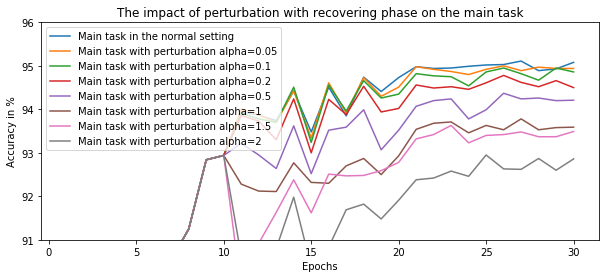

In [12]:
main_results = {k:v for k, v in results.items() if 'Main' in k}
show_results(main_results, "The impact of perturbation with recovering phase on the main task", ymin=91, ymax=96)

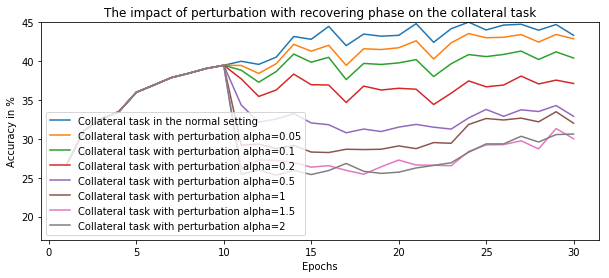

In [38]:
collateral_results = {k:v for k, v in results.items() if 'Collateral' in k}
show_results(collateral_results, "The impact of perturbation with recovering phase on the collateral task", ymin=17, ymax=45)

We only distinguish the difference between phase 1 and 2, when we start perturbing Q against the collateral task; the recovering part is not clearly visible even if we observe that it helps recovering a bit of accuracy in the most perturbed settings.
What we observe is that we achieve a far better trade-off than in Part 9. We assume that the training advantage of the tasks is similar to the one in Part 9, as we have given 30 epochs to improve, including 10 epochs for recovering.
Indeed, while one of the best tradeoff was (34.9, 92.0) in the last part, we now claim to have (30.0, 93.5) !


We report the results for a better visualisation of the trade-off that we have now:

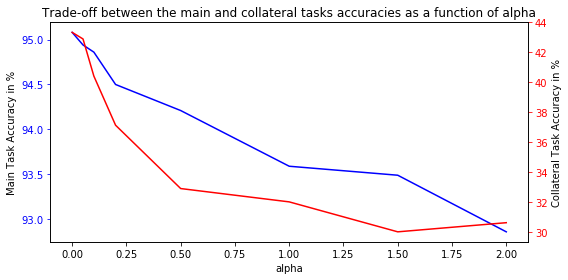

In [33]:
import matplotlib.pyplot as plt

main_scores = []
collateral_scores = []
for k, v in main_results.items():
    main_scores.append(v[-1])
for k, v in collateral_results.items():
    collateral_scores.append(v[-1])
    
alpha_values = [0] + alphas

fig, ax1 = plt.subplots(figsize=(8, 4))

ax1.plot(alpha_values, main_scores, 'b', label='Main Task accuracy')
ax1.set_xlabel('alpha')
ax1.set_ylabel('Main Task Accuracy in %')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.plot(alpha_values, collateral_scores, 'r', label='Collateral Task accuracy')
ax2.set_ylabel('Collateral Task Accuracy in %')
ax2.tick_params('y', colors='r')

plt.title('Trade-off between the main and collateral tasks accuracies as a function of alpha')
fig.tight_layout()
plt.show()

## Conclusion

This technique of joint optimisation gives us very interesting trade-offs. The next questions we can try to solve is to put other models on the private output, on the one hand more classic models as there are only 8 output values, and on the other hand more powerful neural networks to try to increase the ability of the collateral task to recover some information.